#**Milestones 1 Phase 1**
## **Credit Card Classification: Prediction of Default Payments**

Nadia Oktiarsy, FSDS Batch-016 RMT (Buddy: Dian)

---
```
Table of Contents:
1. Introduction
2. Importing Libraries
3. Data Loading
4. Exploratory Data Analysis (EDA)
5. Data Preprocessing
6. Model Definition
7. Model Training
8. Model Evalutation
9. Model Inference
10. Conclusion
```

## **1. Introduction**

Credit card is as the payment method that makes every payment easier. However, each credit card user has their own behaviour in paying the amount of bill that they will get. Thus, **default payment** should be predicted if the credit card user is either responsible to pay the bill or not.

**Default** usually happens after **six months in a row** of not making at least the minimum payment due, which means your credit card is seriously delinquent. During that time you will be contacted by your creditor and they will want to know what you're going to do about it.

### **Problem Statements**

Knowing that default payment is important to predict to prevent users for not owing too much money from the credit card, then the problem statement will be: *do people with this particular credit card tend to have default payment?*

To answer this question, the analysis can be done by Classification models to predict `default_payment_next_month`, using classification machine learning:
- Logistic Regression
- SVM
- Decision Tree
- Random Forest
- KNN
- Naive Bayes
- Other Algorithms (AdaBoostClassifier)

These algorithms are tested based on their baseline/default parameters, and then **cross-validation** will be applied to evaluate each model based on `mean` and also `standard deviation`. The better its cross-validation result, the high chance this algorithm to be chosen and proceeded to the next steps: **Hyperparamter Tuning**, so the predicition with hyperparameter tuning is expectedly to have a better result compared with the default parameters.

## **2. Importing Libraries**

In [194]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
import sys
import sklearn

import warnings
warnings.filterwarnings('ignore')

# Data visualization libraries
import seaborn as sns

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (17,8)

from sklearn import tree

# Feature Selection
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif

# Split Dataset, Standarize, and Hyperparameter Tuning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

# Make pipeline
from sklearn.pipeline import make_pipeline

# For Classification Problems
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# import Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# import KNN
from sklearn.neighbors import KNeighborsClassifier

# import Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Evaluate Classification Models
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# Save and Load Model
import joblib
import json

# GoogleCloud Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'hacktiv8-016-nadiaoktiarsy' # Project ID inserted based on the query results selected to explore
location = 'US'                        # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
auth.authenticate_user()

## **3. Data Loading**

The data loaded is based on dataset `ml_datasets` with name `credit_card_default`. The dataset is quaried on Google Cloud to study the contains, choose and clean the data that are needed. The data contains 2,965 rows and 24 columns with all columns are numerical. **There is no null value**, so for the next step in data preprocessing, missing value will be skipped.

In [2]:
# Creating query
df = client.query('''
SELECT
  limit_balance,
  sex,
  education_level,
  marital_status,
  age,
  pay_0, pay_2, pay_3, pay_4, pay_5, pay_6,
  bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, bill_amt_6,
  pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6,
  default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 31888
''').to_dataframe()

df.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,50000.0,1,3,0,50.0,0.0,0.0,0.0,-1.0,-1,...,3400.0,2769.0,0.0,2266.0,0.0,3400.0,2769.0,1700.0,0.0,0
1,200000.0,2,3,0,45.0,-2.0,-2.0,-2.0,-2.0,-2,...,399.0,1396.0,0.0,2430.0,0.0,399.0,1396.0,0.0,0.0,0
2,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
3,230000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0,...,216260.0,215968.0,174195.0,9405.0,7769.0,7757.0,8030.0,6549.0,5226.0,1
4,50000.0,1,2,1,42.0,0.0,0.0,0.0,0.0,0,...,31320.0,36227.0,35569.0,2007.0,2000.0,1500.0,5400.0,0.0,3000.0,0


In [3]:
df.tail()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2960,320000.0,1,2,1,41.0,1.0,-2.0,-2.0,-2.0,-2,...,0.0,700.0,860.0,0.0,0.0,0.0,700.0,860.0,2420.0,1
2961,20000.0,1,1,1,39.0,-1.0,-1.0,-1.0,-1.0,-1,...,630.0,664.0,598.0,700.0,600.0,700.0,700.0,600.0,1400.0,0
2962,20000.0,1,2,2,25.0,0.0,0.0,0.0,0.0,0,...,16600.0,17025.0,17381.0,1300.0,1300.0,1300.0,700.0,630.0,650.0,0
2963,50000.0,1,2,2,38.0,0.0,0.0,0.0,0.0,0,...,17833.0,18246.0,18642.0,1300.0,1600.0,650.0,700.0,700.0,700.0,0
2964,100000.0,2,1,2,28.0,0.0,0.0,0.0,2.0,0,...,10775.0,10998.0,12655.0,1300.0,3005.0,0.0,700.0,2000.0,1500.0,0


In [4]:
## Downloading csv file
# from google.colab import files
# df.to_csv(r'h8dsft_P1M1_nadia_oktiarsy.csv')
# files.download(r'h8dsft_P1M1_nadia_oktiarsy.csv')

In [5]:
# Checking data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   object 
 2   education_level             2965 non-null   object 
 3   marital_status              2965 non-null   object 
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   object 
 10  pay_6                       2965 non-null   object 
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

Since `pay_5` and `pay_6` are object/string, so it should be converted to float to make them similar with other pay columns.

In [6]:
# Converting pay_5 and pay_6 from string to float
df = df.astype({'pay_5':'float','pay_6':'float'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   object 
 2   education_level             2965 non-null   object 
 3   marital_status              2965 non-null   object 
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

In [7]:
# Checking missing values
df.isnull().sum()

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

**Data description**

Since default payment usually happens after **six months in a row**, so the description of the months of payment and bill, and other information is as below:

Header | Definition
---|---
`limit_balance` | Amount of given credit in NT dollars (includes individual and family/supplementary credit
`sex` | Gender (1=male, 2=female)
`education_level` | Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
`marital_status` | Marital status (1=married, 2=single, 3=others)
`age` | Age in years
**Repayment Status** | Scale: (-2=no consumption, -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
`pay_0` | Repayment status in September, 2005 (scale same as above)
`pay_2` | Repayment status in August, 2005 (scale same as above)
`pay_3` | Repayment status in July, 2005 (scale same as above)
`pay_4` | Repayment status in June, 2005 (scale same as above)
`pay_5` | Repayment status in May, 2005 (scale same as above)
`pay_6` | Repayment status in April, 2005 (scale same as above)
**Billing Amount** | in NT dollar
`bill_amt_1` | Amount of bill statement in September, 2005 (NT dollar)
`bill_amt_2` | Amount of bill statement in August, 2005 (NT dollar)
`bill_amt_3` | Amount of bill statement in July, 2005 (NT dollar)
`bill_amt_4` | Amount of bill statement in June, 2005 (NT dollar)
`bill_amt_5` | Amount of bill statement in May, 2005 (NT dollar)
`bill_amt_6` | Amount of bill statement in April, 2005 (NT dollar)
**Previous Payment** | in NT dollar
`pay_amt_1` | Amount of previous payment in September, 2005 (NT dollar)
`pay_amt_2` | Amount of previous payment in August, 2005 (NT dollar)
`pay_amt_3` | Amount of previous payment in July, 2005 (NT dollar)
`pay_amt_4` | Amount of previous payment in June, 2005 (NT dollar)
`pay_amt_5` | Amount of previous payment in May, 2005 (NT dollar)
`pay_amt_6` | Amount of previous payment in April, 2005 (NT dollar)
**Default Payment** | Target
`default_payment_next_month` | Default payment (1=yes, 0=no)


## **4. Exploratory Data Analysis (EDA)**

Exploratory Data Analysis will be divided into two:
1. General Information, to describe the `default payment` with other variables in general.
2. Correlation Analysis, to describe deeper between `deafult payment` and other variables through correlation analysis.

### **4.1. General Information**

#### **Default Payment Next Month Distribution**

A default payement is a term of missing or multiple missing payments on money that the account owners have borrowed. The distribution of Default Payment is highly imbalanced. **Non-defaults is outnumber defaults almost four times**. This means that **most people pay credit cards on time**, which is `2330` accounts. Meanwhile `635` people do not pay on time.
* `0` : "Yes" (people pay on time)
* `1` : "No" (people do not pay on time)

0    2330
1     635
Name: default_payment_next_month, dtype: int64


Text(0.5, 1.0, 'Histogram of Default Payment for Next Month')

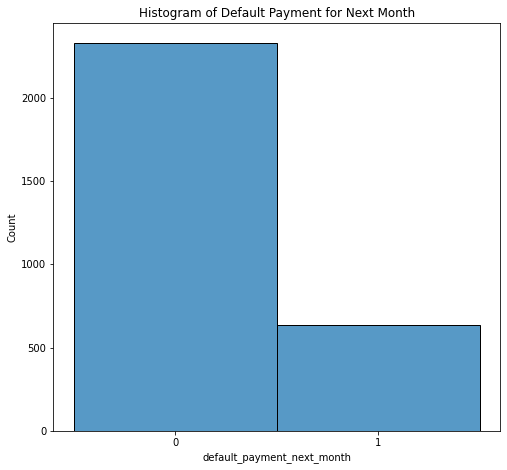

In [8]:
# Create Histogram of Default Payment for Next Month
matplotlib.rcParams['figure.figsize'] = (8,7.5)

print(df.default_payment_next_month.value_counts())

sns.histplot(df['default_payment_next_month'], kde=False)
plt.title('Histogram of Default Payment for Next Month')

#### **Limit Amount**

Limit credit card amount has average `163369.31` NT dollars. The histogram can be one of the consideration for data skewness later.

Average limit balance:  163369.31


Text(0.5, 1.0, 'Histogram of Default Payment for Next Month')

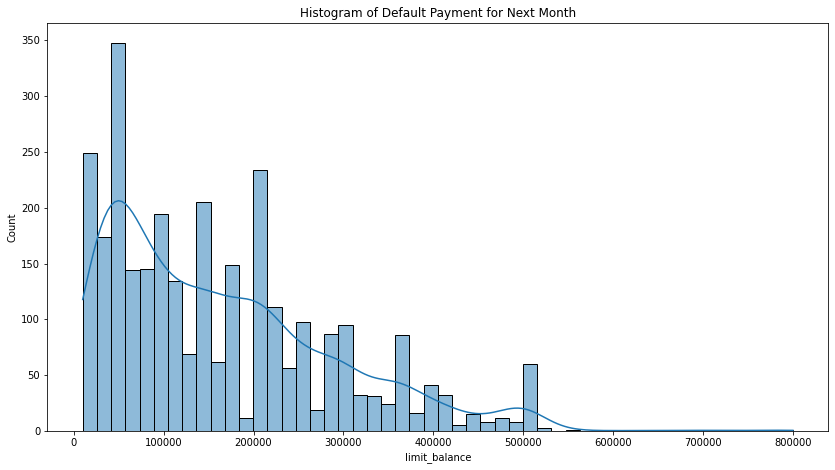

In [9]:
# Create Histogram of Default Payment for Next Month
matplotlib.rcParams['figure.figsize'] = (14,7.5)
print('Average limit balance: ', round(df.limit_balance.mean(), 2))

sns.histplot(df['limit_balance'], kde=True, bins=50)
plt.title('Histogram of Default Payment for Next Month')

#### **General Distribution**

General distribution is to know the population of each feature, to see if there is any balance in each feature. However, we can see that education level has some unknown data.

*Gender distribution*:
- `1` (Male)   : 1163
- `2` (Female) : 1820

In [10]:
# Gender distribution
print(df.sex.value_counts().sort_index())

1    1163
2    1802
Name: sex, dtype: int64


*Education Level distribution*:
- `0` (unknown) : 2
- `1` (graduate school) : 1039
- `2` (university) : 1400
- `3` (high school) : 483
- `4` (others) : 13
- `5` (unknown) : 24
- `6` (unknown) : 4

Apparently values `0`, `5`, and `6` are unknown. These values will be merged for feature selection later.

In [11]:
# Education Level distribution
print(df.education_level.value_counts().sort_index())

0       2
1    1039
2    1400
3     483
4      13
5      24
6       4
Name: education_level, dtype: int64


*Marital Status distribution*:
- `0` (unknown) : 4
- `1` (married) : 1332
- `2` (single) : 1594
- `3` (others) : 35

In [12]:
# Marital Status distribution
print(df.marital_status.value_counts().sort_index())

0       4
1    1332
2    1594
3      35
Name: marital_status, dtype: int64


*Barplots for Gender, Education Level, and Marital Status based on Age*:

- **No difference between male and female's age**. Average males are around 35 years old, meanwhile females are 34 years old.
- **Almost no difference except high school graduates** are mostly above 40 years old. 
- **Most people with 40 years old may be not single**. The average single people are around 30 years old, meanwhile the rest are around and above 40 years old.

Text(0.5, 1.0, 'Barplot of Marital Status based on Age')

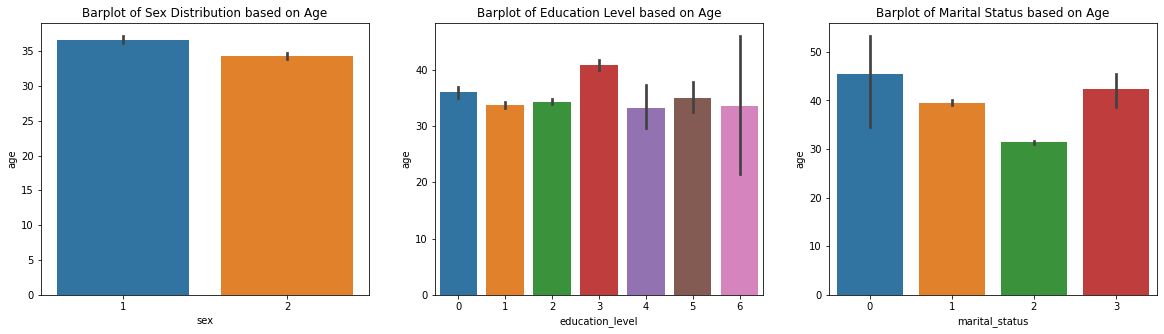

In [13]:
matplotlib.rcParams['figure.figsize'] = (20,5)

# Plotting Gender Distribution
plt.subplot(1, 3, 1)
sns.barplot(data=df, x='sex', y='age')
plt.title('Barplot of Sex Distribution based on Age')

# Plotting Education level Distribution
plt.subplot(1, 3, 2)
sns.barplot(data=df, x='education_level', y='age', order=["0", "1", "2", "3", "4", "5", "6"])
plt.title('Barplot of Education Level based on Age')

# Plotting Marital Status Distribution
plt.subplot(1, 3, 3)
sns.barplot(data=df, x='marital_status', y='age')
plt.title('Barplot of Marital Status based on Age')

#### **Distribution Aggregate of all variables with "Default Payment Next Month"**

The histogram below is about difference of distribusion if we aggregate it with target "Defaul Payment Next Month". According to the observation, we can see that non-default payment is dominating overall. However, there is something important we should notice:

**The amount of bills are higher than the amount of payment that credit card users payed.**

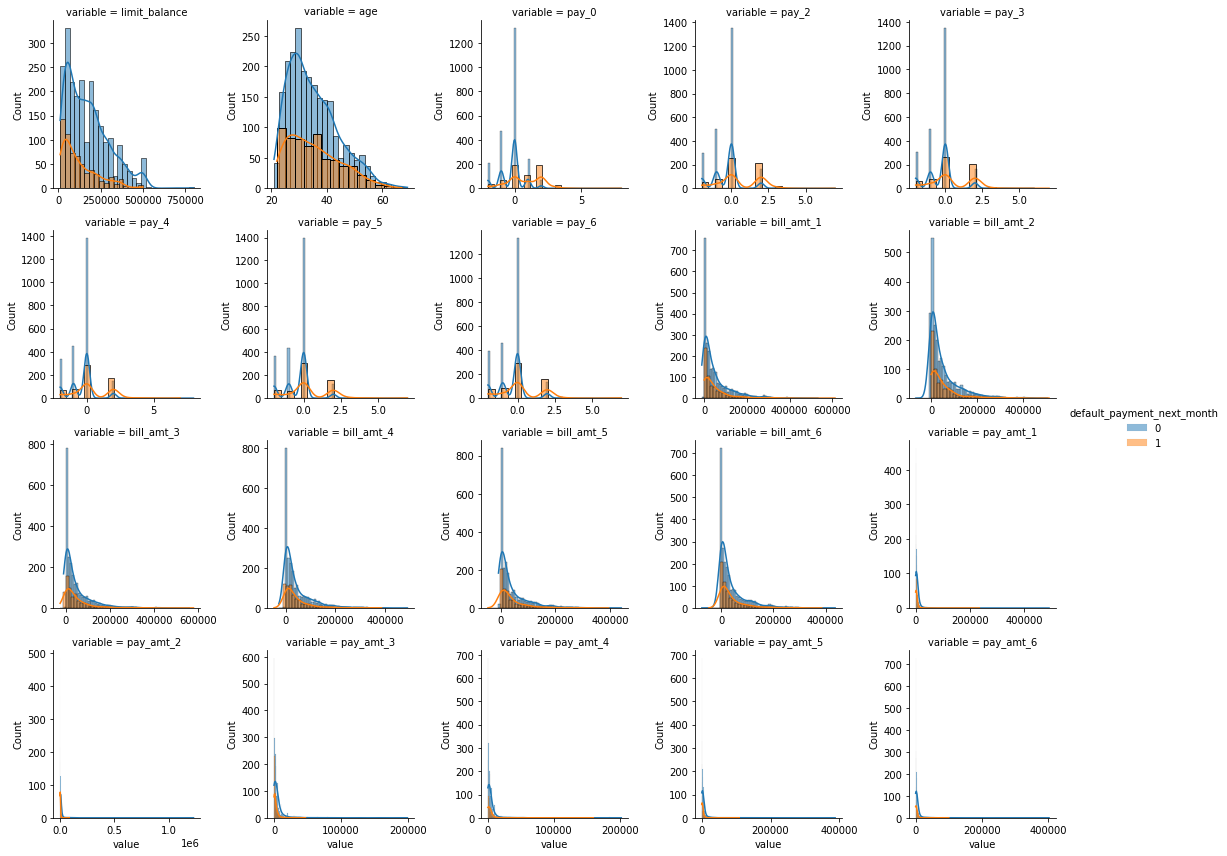

In [14]:
# Creating new dataframe for the histogram
output = 'default_payment_next_month'
cols = [f for f in df.columns if df.dtypes[f] != "object"]
f = pd.melt(df, id_vars=output, value_vars=cols)

# Creating histogram
g = sns.FacetGrid(f, hue=output, col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map(sns.histplot, "value", kde=True).add_legend()

### **4.2. Correlation Analysis**

Correlation analysis will be done by heatmap correlation to see if target has any relationship with features. Merging values between `pay_0`, `pay_5`, and `pay_6` should be done first because of it has the same definition as `unknown`.

After that, labeling will be done for categorical columns, and then concatenate between categorical and numerical columns to find the correlation with the target `default_payment_next_month`.

In [15]:
# Merging unknown values into one value from education_level
df["education_level"] = df['education_level'].replace(['0','5','6'], '0')
df

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,50000.0,1,3,0,50.0,0.0,0.0,0.0,-1.0,-1.0,...,3400.0,2769.0,0.0,2266.0,0.0,3400.0,2769.0,1700.0,0.0,0
1,200000.0,2,3,0,45.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,399.0,1396.0,0.0,2430.0,0.0,399.0,1396.0,0.0,0.0,0
2,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
3,230000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0.0,...,216260.0,215968.0,174195.0,9405.0,7769.0,7757.0,8030.0,6549.0,5226.0,1
4,50000.0,1,2,1,42.0,0.0,0.0,0.0,0.0,0.0,...,31320.0,36227.0,35569.0,2007.0,2000.0,1500.0,5400.0,0.0,3000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,320000.0,1,2,1,41.0,1.0,-2.0,-2.0,-2.0,-2.0,...,0.0,700.0,860.0,0.0,0.0,0.0,700.0,860.0,2420.0,1
2961,20000.0,1,1,1,39.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,630.0,664.0,598.0,700.0,600.0,700.0,700.0,600.0,1400.0,0
2962,20000.0,1,2,2,25.0,0.0,0.0,0.0,0.0,0.0,...,16600.0,17025.0,17381.0,1300.0,1300.0,1300.0,700.0,630.0,650.0,0
2963,50000.0,1,2,2,38.0,0.0,0.0,0.0,0.0,0.0,...,17833.0,18246.0,18642.0,1300.0,1600.0,650.0,700.0,700.0,700.0,0


In [16]:
#  Checking education level after merging some values
df.education_level.value_counts().sort_index()

0      30
1    1039
2    1400
3     483
4      13
Name: education_level, dtype: int64

#### **Correlation DataFrame**

In [17]:
# Creating dataframe for categorical columns
cat_col = ['sex','education_level','marital_status','default_payment_next_month']
df_cat = df[cat_col]

# Using LabelEncoder to make categorical to be numerical feature
le = LabelEncoder()

df_cat_enc = df_cat.copy()
for col in df_cat_enc.select_dtypes(include='O').columns:
    df_cat_enc[col]=le.fit_transform(df_cat_enc[col])
df_cat_enc.head()

,sex,education_level,marital_status,default_payment_next_month
0,0,3,0,0
1,1,3,0,0
2,0,1,1,0
3,0,2,1,1
4,0,2,1,0


In [18]:
# Concatenate data numerical and the labeled target (income_bracket)
df_corr = pd.concat([df, df_cat_enc], axis=1).sort_index()
df_corr

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month,sex,education_level,marital_status,default_payment_next_month
0,50000.0,1,3,0,50.0,0.0,0.0,0.0,-1.0,-1.0,...,0.0,3400.0,2769.0,1700.0,0.0,0,0,3,0,0
1,200000.0,2,3,0,45.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,0.0,399.0,1396.0,0.0,0.0,0,1,3,0,0
2,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,2908.0,2129.0,2354.0,2366.0,2291.0,0,0,1,1,0
3,230000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0.0,...,7769.0,7757.0,8030.0,6549.0,5226.0,1,0,2,1,1
4,50000.0,1,2,1,42.0,0.0,0.0,0.0,0.0,0.0,...,2000.0,1500.0,5400.0,0.0,3000.0,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,320000.0,1,2,1,41.0,1.0,-2.0,-2.0,-2.0,-2.0,...,0.0,0.0,700.0,860.0,2420.0,1,0,2,1,1
2961,20000.0,1,1,1,39.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,600.0,700.0,700.0,600.0,1400.0,0,0,1,1,0
2962,20000.0,1,2,2,25.0,0.0,0.0,0.0,0.0,0.0,...,1300.0,1300.0,700.0,630.0,650.0,0,0,2,2,0
2963,50000.0,1,2,2,38.0,0.0,0.0,0.0,0.0,0.0,...,1600.0,650.0,700.0,700.0,700.0,0,0,2,2,0


#### **Correlation Matrix**

Apparently the correlation between target and features are either weak correlation or no correlation. However, we should try with the other methods if no correlation features in this heatmap are correct. Moreover, as choosing the features are intuitively an art, we can see that some impossible features that we can not remove because of its importance information for banking regardless the statistical result are: `pay`, `bill_amt`, and `pay_amt`.

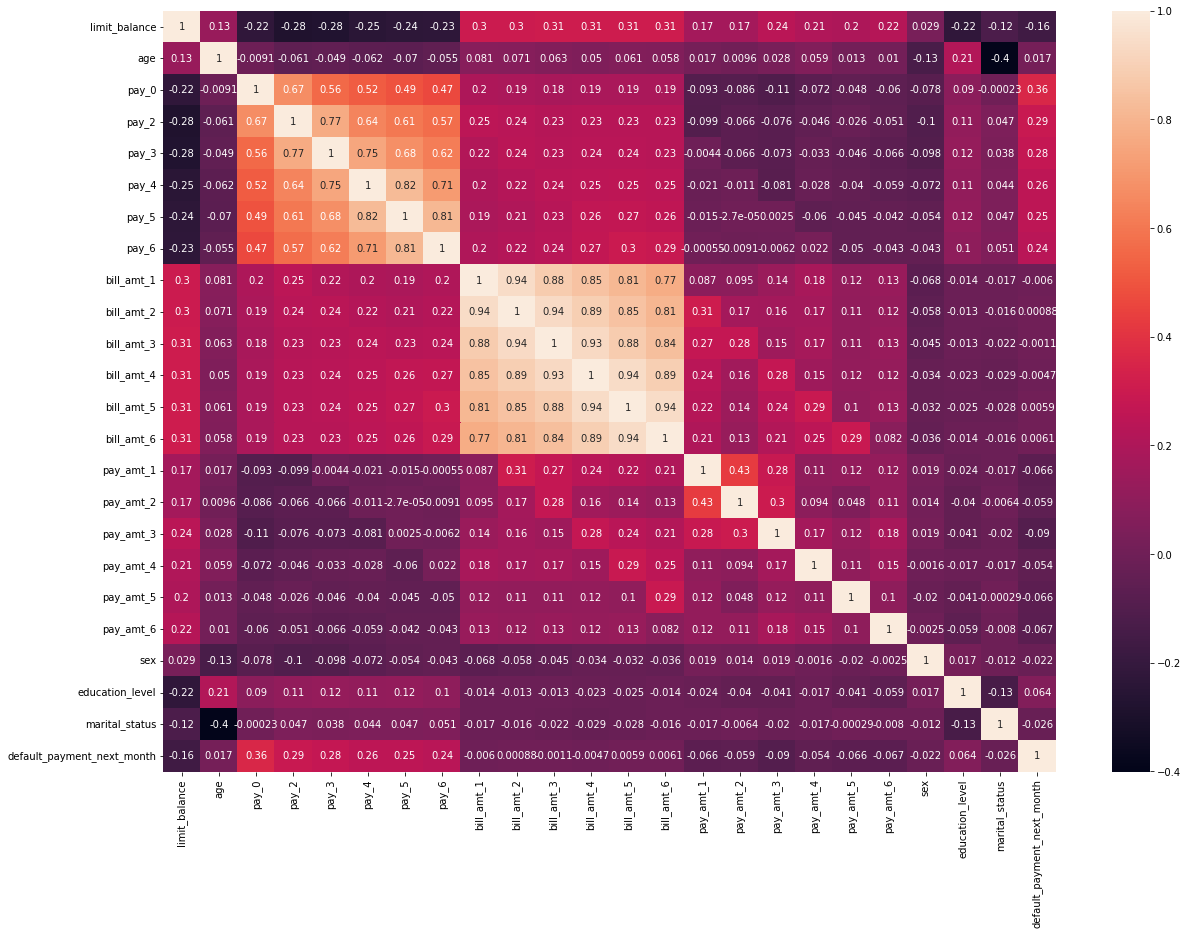

In [19]:
# Plotting Correlation Matrix of Categorical columns and Price
plt.figure(figsize=(20,14))
sns.heatmap(df_corr.corr(),annot=True)

## **5. Data Preprocessing**

### **5.1. Data Inference**

Data inference will take `300` random rows, which we can see the table below. The number of data itself is based on 10% of the overall index. So, the data for train and test set will be `2635 rows × 24 columns`.

In [164]:
# Creating data inference
df_inf = df.sample(300, random_state=32).sort_index()
df_inf

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
7,130000.0,2,3,1,43.0,0.0,0.0,0.0,0.0,0.0,...,98071.0,97743.0,100124.0,5540.0,4403.0,3814.0,3562.0,4021.0,3681.0,0
18,50000.0,1,2,1,40.0,0.0,0.0,0.0,0.0,0.0,...,44356.0,19344.0,19354.0,1691.0,1942.0,1296.0,674.0,693.0,1000.0,0
23,140000.0,1,2,1,29.0,0.0,0.0,0.0,0.0,0.0,...,132038.0,131961.0,124256.0,6696.0,5000.0,4866.0,5300.0,5055.0,5000.0,0
26,80000.0,2,2,1,29.0,0.0,0.0,2.0,2.0,0.0,...,55081.0,55350.0,55906.0,5120.0,2600.0,0.0,2200.0,2028.0,3000.0,0
69,80000.0,2,2,1,48.0,0.0,0.0,0.0,0.0,0.0,...,25670.0,30089.0,29395.0,2264.0,1420.0,1002.0,6005.0,2000.0,970.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2858,130000.0,2,2,2,25.0,-1.0,-1.0,-1.0,0.0,0.0,...,23150.0,27376.0,33104.0,780.0,36659.0,5000.0,5000.0,7000.0,5000.0,0
2883,310000.0,2,1,2,29.0,0.0,0.0,0.0,0.0,0.0,...,41540.0,50803.0,59927.0,14750.0,5000.0,24000.0,10000.0,10000.0,30000.0,0
2952,20000.0,1,2,1,24.0,0.0,0.0,0.0,0.0,0.0,...,12714.0,13059.0,13193.0,1500.0,1600.0,700.0,700.0,500.0,1000.0,1
2959,120000.0,2,2,1,54.0,1.0,-2.0,-2.0,-2.0,-1.0,...,0.0,700.0,1935.0,0.0,0.0,200.0,700.0,1935.0,0.0,1


In [165]:
# Drop data inference as a new dataframe
df_train_test = df.drop(df_inf.index)
df_train_test

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,50000.0,1,3,0,50.0,0.0,0.0,0.0,-1.0,-1.0,...,3400.0,2769.0,0.0,2266.0,0.0,3400.0,2769.0,1700.0,0.0,0
1,200000.0,2,3,0,45.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,399.0,1396.0,0.0,2430.0,0.0,399.0,1396.0,0.0,0.0,0
2,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
3,230000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0.0,...,216260.0,215968.0,174195.0,9405.0,7769.0,7757.0,8030.0,6549.0,5226.0,1
4,50000.0,1,2,1,42.0,0.0,0.0,0.0,0.0,0.0,...,31320.0,36227.0,35569.0,2007.0,2000.0,1500.0,5400.0,0.0,3000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2958,80000.0,2,1,1,25.0,3.0,2.0,2.0,2.0,3.0,...,8073.0,8349.0,8420.0,1200.0,300.0,1100.0,700.0,500.0,0.0,1
2960,320000.0,1,2,1,41.0,1.0,-2.0,-2.0,-2.0,-2.0,...,0.0,700.0,860.0,0.0,0.0,0.0,700.0,860.0,2420.0,1
2961,20000.0,1,1,1,39.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,630.0,664.0,598.0,700.0,600.0,700.0,700.0,600.0,1400.0,0
2963,50000.0,1,2,2,38.0,0.0,0.0,0.0,0.0,0.0,...,17833.0,18246.0,18642.0,1300.0,1600.0,650.0,700.0,700.0,700.0,0


### **5.2. Train and Test Set**

This part is to separate data into train, validation, and test splits, **to prevent your model from overfitting**, and **to accurately evaluate model**. From the train and test set, the features from the data set after handling outliers will drop `default_payment_next_month` because it should be the target.

In [166]:
# Defining X and y
X = df_train_test.drop(['default_payment_next_month'],axis=1)
y = pd.DataFrame(df_train_test['default_payment_next_month'])
X.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,50000.0,1,3,0,50.0,0.0,0.0,0.0,-1.0,-1.0,...,0.0,3400.0,2769.0,0.0,2266.0,0.0,3400.0,2769.0,1700.0,0.0
1,200000.0,2,3,0,45.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,0.0,399.0,1396.0,0.0,2430.0,0.0,399.0,1396.0,0.0,0.0
2,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0
3,230000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0.0,...,213058.0,216260.0,215968.0,174195.0,9405.0,7769.0,7757.0,8030.0,6549.0,5226.0
4,50000.0,1,2,1,42.0,0.0,0.0,0.0,0.0,0.0,...,30660.0,31320.0,36227.0,35569.0,2007.0,2000.0,1500.0,5400.0,0.0,3000.0


In [168]:
y

,default_payment_next_month
0,0
1,0
2,0
3,1
4,0
...,...
2958,1
2960,1
2961,0
2963,0


In [24]:
# Seperating dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=69)

print('Train size : ', X_train.shape)
print('Test size. : ', X_test.shape)

Train size :  (1865, 23)
Test size. :  (800, 23)


In [25]:
# Calling features variable train set
X_train.sort_index()

# Calling features variable test set
X_test.sort_index()

# Calling target variable train set
y_train.sort_index()

# Calling target variable test set
y_test.sort_index()

X_train

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
980,50000.0,1,2,2,24.0,0.0,0.0,0.0,0.0,0.0,...,49158.0,19270.0,18776.0,19167.0,2063.0,1298.0,700.0,800.0,815.0,237.0
2300,50000.0,2,2,2,23.0,2.0,0.0,0.0,0.0,0.0,...,26283.0,26547.0,27119.0,27697.0,2000.0,2000.0,1000.0,1000.0,1028.0,1000.0
1338,180000.0,2,1,2,39.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-6674.0,18084.0,16481.0,19359.0,6653.0,330.0,36550.0,16481.0,21264.0,16253.0
1779,370000.0,1,1,1,40.0,1.0,-2.0,-2.0,-2.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2214,280000.0,2,1,2,25.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,500.0,0.0,500.0,4778.0,505.0,500.0,0.0,500.0,4778.0,4898.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,80000.0,2,2,2,31.0,0.0,0.0,0.0,0.0,-1.0,...,17495.0,13198.0,10287.0,3275.0,2302.0,1774.0,1000.0,10287.0,3295.0,4122.0
308,100000.0,1,3,1,35.0,0.0,0.0,0.0,0.0,0.0,...,74239.0,75704.0,55704.0,56810.0,3938.0,2515.0,2516.0,4022.0,2032.0,2112.0
2733,480000.0,2,1,1,43.0,0.0,0.0,0.0,0.0,0.0,...,288120.0,294000.0,300000.0,3493.0,5647.0,5792.0,5880.0,6000.0,3493.0,21308.0
489,360000.0,2,1,1,57.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,1422.0,0.0,0.0,0.0,0.0,1424.0,0.0,6624.0


### **5.3. Data Skewness**

Based on the skewness of the data, we can find that both Train set and Test set are `Right Skewed`. This will be useful for outliers later. The data that will be taken to describe the data skewness is from `limit_balance`, since it is an important feature that each credit card company needs to set.

As the result:
```
'limit_balance' skewness: 1.074844234110538
Right skewed
```

In [26]:
# Creating a function to print the skewness
def print_skewness(data):
    print(f'\'{data.name}\' skewness: {data.skew()}')
    # print(f'\'{data.name}\'kurtosis: {data.kurt()}')
    if data.skew() > 0.5:
        print ('Right skewed')
    elif data.skew() < -0.5:
        print( 'Left Skewed')
    else:
        print("Normal Distribution")

# Creating a function to visualize the data
def visualize_data(data):
    print_skewness(data)
    plt.hist(data, bins=65, rwidth=1, density=True)
    plt.xlabel(f'{data.name}')
    plt.ylabel('Probability Density')
    rng = np.arange(data.min(), data.max(), 0.1)
    plt.plot(rng, norm.pdf(rng,data.mean(),data.std()))

    # label the plot
    plt.legend(['Normal PDF(Probability Density Function) ', 'Histogram: Load Weight'])
    plt.axvline(data.mean(), color='magenta', linestyle='dashed', linewidth=2)
    plt.axvline(data.median(), color='green', linestyle='dashed', linewidth=2)
    plt.axvline(data.mode()[0], color='red', linestyle='dashed', linewidth=2)
    plt.show()

'limit_balance' skewness: 1.074844234110538
Right skewed


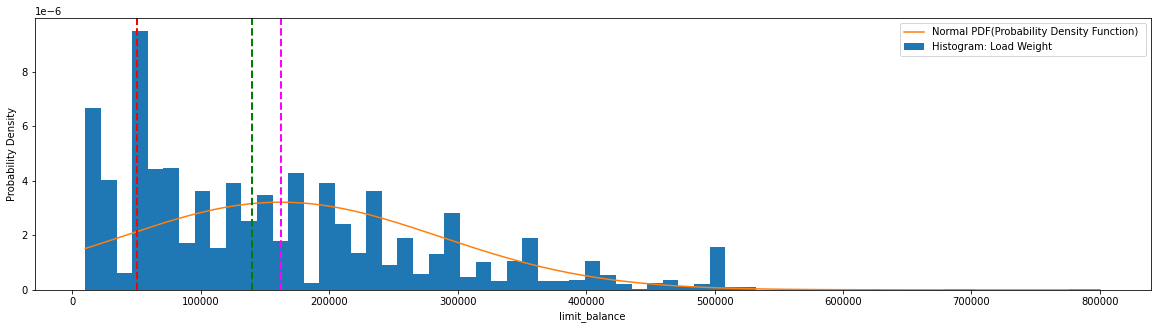

In [27]:
# Visualizing skewed data for X_train
visualize_data(X_train.limit_balance)

### **5.4. Outliers**

Since the skewness is discovered as a **Right Skewed**, thus the following ouliers handling will be **Tukey's Rule**, with 1.5 times the interquartile range from the quartiles (1.5IQR). However, for variables with six months features (such as `pay`, `bill_amt`, and `pay_amt`) will be taken its mean. Then, the corresponding mean will be checked its outliers.

In [28]:
# Creating Mean for "Pay", "Bill Amount" and "Pay Amount"
X_train["pay_mean"] = round(X_train.loc[:, ['pay_0','pay_2','pay_3','pay_4','pay_5']].mean(axis = 1),2)
X_train["bill_mean"] = round(X_train.loc[:, ['bill_amt_1','bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5','bill_amt_6']].mean(axis = 1),2)
X_train["pay_amt_mean"] = round(X_train.loc[:, ['pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4','pay_amt_5','pay_amt_6']].mean(axis = 1),2)
X_train.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,pay_mean,bill_mean,pay_amt_mean
980,50000.0,1,2,2,24.0,0.0,0.0,0.0,0.0,0.0,...,19167.0,2063.0,1298.0,700.0,800.0,815.0,237.0,0.0,34061.67,985.50
2300,50000.0,2,2,2,23.0,2.0,0.0,0.0,0.0,0.0,...,27697.0,2000.0,2000.0,1000.0,1000.0,1028.0,1000.0,0.4,31075.67,1338.00
1338,180000.0,2,1,2,39.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,19359.0,6653.0,330.0,36550.0,16481.0,21264.0,16253.0,-2.0,10939.17,16255.17
1779,370000.0,1,1,1,40.0,1.0,-2.0,-2.0,-2.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4,0.00,0.00
2214,280000.0,2,1,2,25.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,4778.0,505.0,500.0,0.0,500.0,4778.0,4898.0,-2.0,1210.50,1863.50


Text(0, 0.5, 'pay_amt_mean')

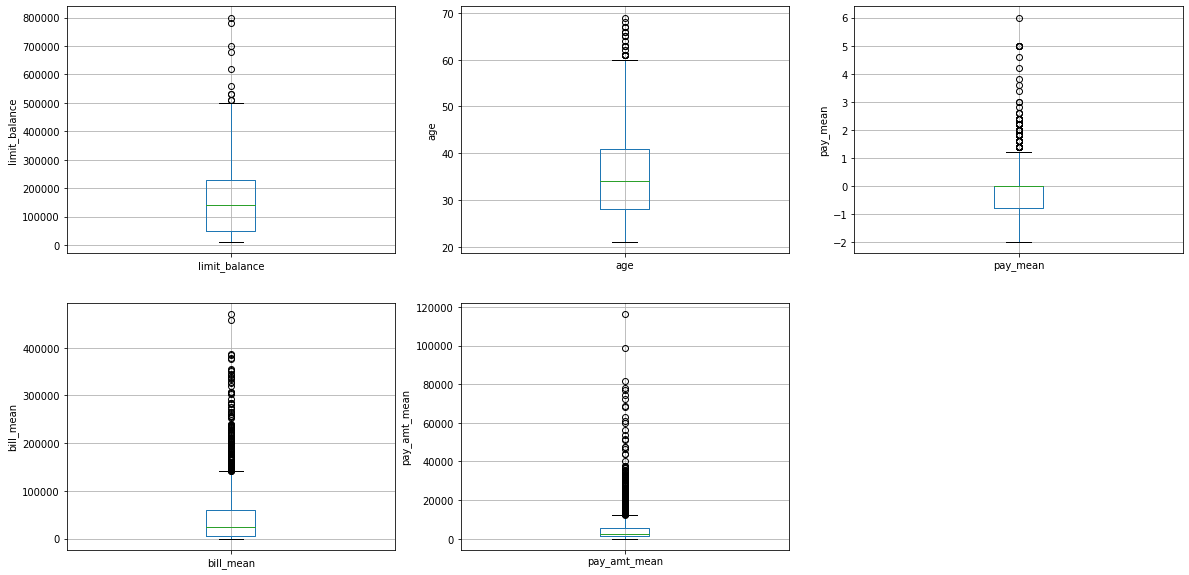

In [29]:
# Draw boxplots to visualize outliers

plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
fig1 = X_train.boxplot(column='limit_balance')
fig1.set_title('')
fig1.set_ylabel('limit_balance')

plt.subplot(2, 3, 2)
fig2 = X_train.boxplot(column='age')
fig2.set_title('')
fig2.set_ylabel('age')

plt.subplot(2, 3, 3)
fig3 = X_train.boxplot(column='pay_mean')
fig3.set_title('')
fig3.set_ylabel('pay_mean')

plt.subplot(2, 3, 4)
fig3 = X_train.boxplot(column='bill_mean')
fig3.set_title('')
fig3.set_ylabel('bill_mean')

plt.subplot(2, 3, 5)
fig3 = X_train.boxplot(column='pay_amt_mean')
fig3.set_title('')
fig3.set_ylabel('pay_amt_mean')

It can be seen that the comparison each variable has **right skewed** and outliers are distributed outside the fence. This is obvious to handle outliers with Tukey's Rule, by using 1.5IQR. Apparently, we can see that there are only 10 indexes as the outliers. Thus, we can omit those indexes.

In [30]:
# Calculating Limit for `limit_balance` for train set
Q1 = X_train['limit_balance'].quantile(0.25)
Q3 = X_train['limit_balance'].quantile(0.75)
IQR = Q3 - Q1

# Calculating Upper Limit Fence
upper_limit = X_train[X_train['limit_balance']>(Q3+(1.5*IQR))]

# Calculating Lower Limit Fence
lower_limit = X_train[X_train['limit_balance']<(Q1-(1.5*IQR))]

upper_limit

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,pay_mean,bill_mean,pay_amt_mean
787,530000.0,2,1,2,39.0,0.0,0.0,0.0,0.0,0.0,...,352736.0,17045.0,14089.0,11962.0,11763.0,12557.0,12496.0,0.0,376111.67,13318.67
1072,560000.0,2,1,2,32.0,0.0,0.0,0.0,0.0,0.0,...,11400.0,1548.0,1446.0,14720.0,427.0,1000.0,300.0,0.0,27144.67,3240.17
446,530000.0,1,2,1,54.0,-2.0,-2.0,-2.0,-2.0,-1.0,...,129716.0,0.0,1200.0,390.0,166210.0,6000.0,3000.0,-1.8,49376.00,29466.67
544,800000.0,1,2,1,53.0,-1.0,-1.0,-1.0,0.0,0.0,...,9339.0,11145.0,64657.0,131.0,247.0,9366.0,63482.0,-0.6,23411.50,24838.00
1490,620000.0,2,1,2,38.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,2867.0,8638.0,620.0,16032.0,2856.0,4197.0,920.0,-1.0,7027.33,5543.83
36,780000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,191090.0,10000.0,15004.0,10000.0,8000.0,10028.0,7003.0,0.0,185299.17,10005.83
2574,510000.0,2,2,1,38.0,0.0,0.0,0.0,0.0,0.0,...,41153.0,2000.0,2700.0,2700.0,1500.0,1500.0,10000.0,0.0,48176.00,3400.00
260,700000.0,2,1,1,36.0,0.0,0.0,0.0,0.0,0.0,...,286805.0,13000.0,11939.0,10312.0,20004.0,20000.0,20000.0,0.0,342091.83,15875.83
64,510000.0,2,3,1,61.0,0.0,0.0,2.0,0.0,0.0,...,216225.0,17000.0,0.0,6508.0,50000.0,7000.0,6000.0,0.4,195656.83,14418.00
2523,680000.0,2,1,1,42.0,0.0,0.0,0.0,0.0,0.0,...,177731.0,8000.0,9000.0,7000.0,7000.0,7000.0,7000.0,0.0,185064.50,7500.00


In [31]:
# Checking size before and after removing outliers for Train set
print('Size before removing outliers (Train):',X_train.shape)
X_train_final = X_train[~((X_train['limit_balance']>(Q3+(1.5*IQR))))]
X_train_final = X_train_final.drop(['pay_mean','bill_mean','pay_amt_mean'],axis=1)
print('Size after removing outliers (Train):', X_train_final.shape)

# Checking size before and after removing outliers for Test set
print('Size before removing outliers (Test):',X_test.shape)
X_test_final = X_test[~((X_test['limit_balance']>(Q3+(1.5*IQR))))]
print('Size after removing outliers (Test):', X_test_final.shape)

Size before removing outliers (Train): (1865, 26)
Size after removing outliers (Train): (1855, 23)
Size before removing outliers (Test): (800, 23)
Size after removing outliers (Test): (798, 23)


The `limit_balance` is important in credit card banking, then the outliers are removed so we can get the interquartile 1 (Q1) around `50,000 NT` and interquartile 3 (Q3) is around `230,000 NT`.

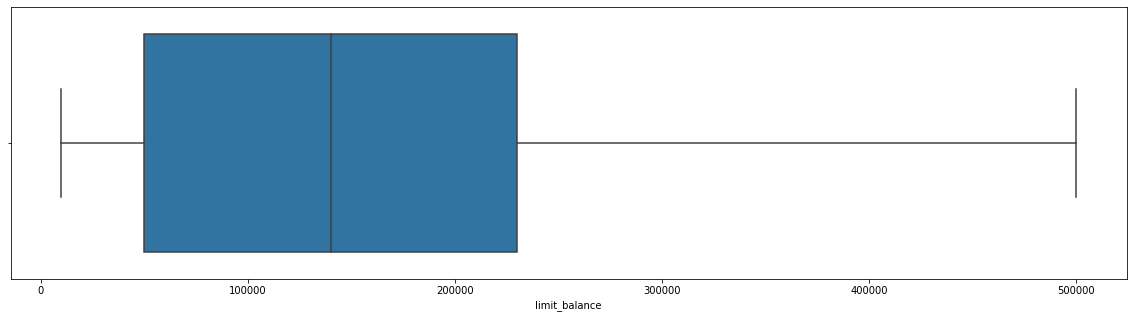

In [32]:
# Checking boxplot after removing outliers
sns.boxplot(x = X_train_final['limit_balance'])
plt.show()

In [33]:
# Checking if train and test set features have missing values
print('Missing values train set features:', X_train_final.isna().sum().sum())
print('Missing values test set features:', X_test_final.isna().sum().sum())

Missing values train set features: 0
Missing values test set features: 0


**Target Train and Test Set**

Outliers for target should be applied as well.

In [34]:
# Checking size before and after removing outliers for X_train
print('Target Train size before removing outliers:',y_train.shape)
y_train = y_train[~((X_train['limit_balance']>(Q3+(1.5*IQR))))]
print('Target Train size after removing outliers:', y_train.shape)

print('Target Test size before removing outliers:',y_test.shape)
y_test = y_test[~((X_test['limit_balance']>(Q3+(1.5*IQR))))]
print('Target Test size after removing outliers:', y_test.shape)

Target Train size before removing outliers: (1865, 1)
Target Train size after removing outliers: (1855, 1)
Target Test size before removing outliers: (800, 1)
Target Test size after removing outliers: (798, 1)


### **5.5. Features Selection**

In feature selection, the dataset after outliers removal will be used. And then we should seperate it between numerical and categorical features, so it can be encoded and scaled.

These encoding and scaling will be useful for analyzing chi-square, where we also select which variables that can be **dropped, because of its low correlation and significance**.

In [35]:
# Calling X_train_final
X_train_final.sort_index()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,50000.0,1,3,0,50.0,0.0,0.0,0.0,-1.0,-1.0,...,0.0,3400.0,2769.0,0.0,2266.0,0.0,3400.0,2769.0,1700.0,0.0
2,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0
3,230000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0.0,...,213058.0,216260.0,215968.0,174195.0,9405.0,7769.0,7757.0,8030.0,6549.0,5226.0
4,50000.0,1,2,1,42.0,0.0,0.0,0.0,0.0,0.0,...,30660.0,31320.0,36227.0,35569.0,2007.0,2000.0,1500.0,5400.0,0.0,3000.0
8,90000.0,2,2,1,35.0,2.0,0.0,0.0,0.0,0.0,...,55010.0,52540.0,56236.0,40922.0,2700.0,2500.0,1900.0,4600.0,0.0,1600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2957,50000.0,2,3,1,52.0,1.0,2.0,0.0,0.0,0.0,...,19469.0,20412.0,19755.0,20320.0,0.0,1700.0,1600.0,700.0,840.0,700.0
2958,80000.0,2,1,1,25.0,3.0,2.0,2.0,2.0,3.0,...,7246.0,8073.0,8349.0,8420.0,1200.0,300.0,1100.0,700.0,500.0,0.0
2960,320000.0,1,2,1,41.0,1.0,-2.0,-2.0,-2.0,-2.0,...,0.0,0.0,700.0,860.0,0.0,0.0,0.0,700.0,860.0,2420.0
2961,20000.0,1,1,1,39.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,596.0,630.0,664.0,598.0,700.0,600.0,700.0,700.0,600.0,1400.0


In [36]:
# Splitting between numerical columns and categorical columns
num_columns = X_train_final.select_dtypes(include=np.number).columns.tolist()
cat_columns = X_train_final.select_dtypes(include=['object']).columns.tolist()

print('Numerical columns  : ', num_columns)
print('Categorical columns  : ', cat_columns)

Numerical columns  :  ['limit_balance', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']
Categorical columns  :  ['sex', 'education_level', 'marital_status']


#### **5.5.1. Feature Scaling: MinMaxScaler**

Feature scaling will be using Normalization because of data skewness as **Right Skewed**. It is important to scale the data with MinMaxScaler, because of its ordinality.

In [37]:
# Split Numerical Features
X_train_num = X_train_final[num_columns]
X_test_num = X_test_final[num_columns]

# Split Categorical Features
X_train_cat = X_train_final[cat_columns]
X_test_cat = X_test_final[cat_columns]

In [38]:
# Checking numerical dataframe
X_train_num = X_train_num.sort_index()
X_test_num = X_test_num.sort_index()
X_train_num

,limit_balance,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,50000.0,50.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,45771.0,23343.0,0.0,3400.0,2769.0,0.0,2266.0,0.0,3400.0,2769.0,1700.0,0.0
2,130000.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0
3,230000.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,301038.0,305327.0,213058.0,216260.0,215968.0,174195.0,9405.0,7769.0,7757.0,8030.0,6549.0,5226.0
4,50000.0,42.0,0.0,0.0,0.0,0.0,0.0,2.0,35892.0,32546.0,30660.0,31320.0,36227.0,35569.0,2007.0,2000.0,1500.0,5400.0,0.0,3000.0
8,90000.0,35.0,2.0,0.0,0.0,0.0,0.0,2.0,63426.0,57922.0,55010.0,52540.0,56236.0,40922.0,2700.0,2500.0,1900.0,4600.0,0.0,1600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2957,50000.0,52.0,1.0,2.0,0.0,0.0,0.0,0.0,19371.0,18761.0,19469.0,20412.0,19755.0,20320.0,0.0,1700.0,1600.0,700.0,840.0,700.0
2958,80000.0,25.0,3.0,2.0,2.0,2.0,3.0,3.0,6269.0,7212.0,7246.0,8073.0,8349.0,8420.0,1200.0,300.0,1100.0,700.0,500.0,0.0
2960,320000.0,41.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,700.0,860.0,0.0,0.0,0.0,700.0,860.0,2420.0
2961,20000.0,39.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,628.0,662.0,596.0,630.0,664.0,598.0,700.0,600.0,700.0,700.0,600.0,1400.0


In [39]:
# Making feature scaling for numerical columns with Normalizaation - MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_num)
scaler.fit(X_test_num)

X_train_num_scaled = scaler.transform(X_train_num)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns, index = X_train_num.index)

X_test_num_scaled = scaler.transform(X_test_num)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns = X_test_num.columns, index = X_test_num.index)

X_test_num_scaled

,limit_balance,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
1,0.387755,0.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.007622,0.138815,0.022916,0.062399,0.023561,0.124309,0.013191,0.000000,0.002291,0.008744,0.000000,0.000000
5,0.265306,0.270833,0.2,0.222222,0.222222,0.222222,0.222222,0.222222,0.279243,0.404230,0.347266,0.376897,0.396616,0.457272,0.038000,0.012059,0.030430,0.033196,0.043698,0.023653
6,0.020408,0.583333,0.2,0.222222,0.222222,0.222222,0.222222,0.222222,0.034677,0.162911,0.058487,0.097976,0.065203,0.165534,0.008376,0.002171,0.007292,0.003720,0.002669,0.006242
16,0.591837,0.312500,0.2,0.222222,0.222222,0.222222,0.222222,0.222222,0.567753,0.638165,0.610176,0.630168,0.705145,0.721412,0.050219,0.018098,0.052575,0.058369,0.041535,0.037232
20,0.183673,0.104167,0.2,0.222222,0.222222,0.222222,0.222222,0.222222,0.100959,0.227453,0.116037,0.145936,0.116648,0.207262,0.027143,0.004307,0.017225,0.010003,0.010630,0.024792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2943,0.102041,0.104167,0.2,0.222222,0.222222,0.222222,0.222222,0.222222,0.126263,0.241119,0.133220,0.143233,0.096776,0.194652,0.013028,0.003532,0.011546,0.007516,0.006057,0.005256
2946,0.020408,0.166667,0.5,0.444444,0.444444,0.444444,0.222222,0.222222,0.040369,0.165314,0.065257,0.100914,0.069980,0.172555,0.000000,0.005168,0.000000,0.007516,0.007788,0.000000
2947,0.183673,0.083333,0.3,0.444444,0.222222,0.222222,0.222222,0.222222,0.206745,0.309796,0.230478,0.203008,0.135989,0.224423,0.000000,0.008528,0.013780,0.007516,0.006057,0.005269
2951,0.081633,0.437500,0.2,0.222222,0.222222,0.222222,0.222222,0.222222,0.030683,0.159077,0.055377,0.092660,0.059118,0.159793,0.006601,0.002632,0.002865,0.004384,0.002596,0.002370


#### **5.5.2. Feature Encoding: Categorical**

In [40]:
# Making feature encoding for categorical columns
X_train_cat = X_train_cat[cat_columns].sort_index()
X_test_cat = X_test_cat[cat_columns].sort_index()
X_train_cat

,sex,education_level,marital_status
0,1,3,0
2,1,1,1
3,1,2,1
4,1,2,1
8,2,2,1
...,...,...,...
2957,2,3,1
2958,2,1,1
2960,1,2,1
2961,1,1,1


In [41]:
# Encoding categorical columns for chi-square
enc = OrdinalEncoder()
ordinal_cat_train = X_train_cat.copy()
ordinal_cat_test = X_test_cat.copy()

# Encoding ordinal category Train set
ordinal_cat_train = enc.fit_transform(X_train_cat)
ordinal_cat_train = pd.DataFrame(ordinal_cat_train, index=X_train_cat.index, columns=X_train_cat.columns).sort_index()

# Encoding ordinal category Test set
ordinal_cat_test = enc.fit_transform(X_test_cat)
ordinal_cat_test = pd.DataFrame(ordinal_cat_test, index=X_test_cat.index, columns=X_test_cat.columns).sort_index()
ordinal_cat_test

,sex,education_level,marital_status
1,1.0,3.0,0.0
5,1.0,2.0,1.0
6,1.0,2.0,1.0
16,1.0,1.0,1.0
20,1.0,3.0,1.0
...,...,...,...
2943,1.0,2.0,2.0
2946,0.0,1.0,2.0
2947,1.0,1.0,2.0
2951,1.0,2.0,1.0


#### **5.5.3. Chi-square**

A chi-square test is performed at a certain level of significance, usually **5%** (α = 0.05; p = . 95). At a 5% significance level, we are saying that there is less than a 5% chance that the null hypothesis will be rejected even though it is true.

We can see from the train set and test set that education level is apparently not as significant as others, which is lower than 5%. Moreover, based on the correlation analysis before, education level is also included as not correlated with the target.

In summary, **education level will be dropped because of its low correlation and significance**.

In [42]:
# k = 4 tells four top features to be selected
# Score function Chi2 tells the feature to be selected using Chi Square
train = SelectKBest(score_func=chi2, k=3)
fit = train.fit(ordinal_cat_train, y_train)

chi = pd.Series(fit.scores_)
chi.index = ordinal_cat_train.columns
chi.sort_values(ascending=False)

marital_status     0.098397
education_level    0.011052
sex                0.005861
dtype: float64

In [43]:
# k = 4 tells four top features to be selected
# Score function Chi2 tells the feature to be selected using Chi Square
test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(ordinal_cat_test, y_test)

chi = pd.Series(fit.scores_)
chi.index = ordinal_cat_test.columns
chi.sort_values(ascending=False)

sex                0.458619
marital_status     0.289866
education_level    0.037125
dtype: float64

### **5.6. Final Result from Data Preprocessing**

The final result from data processing will show when numerical and categorical features are concatenated, and then the features with low correlation and chi2 (which is `education_level`) will be removed. The numerical features is already scaled with **MinMaxEncoder** and the categorical will be encoded by **OneHotEncoder**.

In [44]:
# OneHotEncoder will be used for encoding, because there is no need to rank
ohc = OneHotEncoder()

# Encoding OneHotEncoder (ohc) based on the labeled X_train_cat
X_train_cat_encoded = ohc.fit_transform(X_train_cat).toarray()
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded, index=X_train_cat.index).sort_index()

X_test_cat_encoded = ohc.transform(X_test_cat).toarray()
X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, index = X_test_cat.index).sort_index()

# Renaming columns
X_train_cat_encoded = X_train_cat_encoded.rename(columns={0: "male",
                                                          1: "female",
                                                          2: "unknown_education",
                                                          3: "graduate_school",
                                                          4: "university",
                                                          5: "high_school",
                                                          6: "other_education",
                                                          7: "unknown_marital_status",
                                                          8: "married",
                                                          9: "single",
                                                          10: "other_marital"})

X_test_cat_encoded = X_test_cat_encoded.rename(columns={0: "male",
                                                        1: "female",
                                                        2: "unknown_education",
                                                        3: "graduate_school",
                                                        4: "university",
                                                        5: "high_school",
                                                        6: "other_education",
                                                        7: "unknown_marital_status",
                                                        8: "married",
                                                        9: "single",
                                                        10: "other_marital"})

# Drop features 
X_train_cat_encoded = X_train_cat_encoded.drop(['unknown_education','graduate_school','university','high_school','other_education'],axis=1)
X_test_cat_encoded = X_test_cat_encoded.drop(['unknown_education','graduate_school','university','high_school','other_education'],axis=1)

**Features Dataset**

In [45]:
# Concatenate dataframe X_train_final
X_train_final = pd.concat([X_train_cat_encoded, X_train_num_scaled], axis=1)
X_train_final = X_train_final.sort_index()

# Concatenate dataframe X_test_final
X_test_final = pd.concat([X_test_cat_encoded, X_test_num_scaled], axis=1)
X_test_final = X_test_final.sort_index()

X_train_final

,male,female,unknown_marital_status,married,single,other_marital,limit_balance,age,pay_0,pay_2,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,1.0,0.0,1.0,0.0,0.0,0.0,0.081633,0.604167,0.2,0.222222,...,0.022916,0.069114,0.027315,0.124309,0.012301,0.000000,0.019521,0.017343,0.007355,0.000000
2,1.0,0.0,0.0,1.0,0.0,0.0,0.244898,0.500000,0.2,0.222222,...,0.165192,0.201070,0.194295,0.282416,0.015667,0.005010,0.012224,0.014744,0.010237,0.010035
3,1.0,0.0,0.0,1.0,0.0,0.0,0.448980,0.416667,0.2,0.222222,...,0.518586,0.545370,0.610319,0.547379,0.051055,0.013384,0.044537,0.050295,0.028334,0.022891
4,1.0,0.0,0.0,1.0,0.0,0.0,0.081633,0.437500,0.2,0.222222,...,0.094245,0.131582,0.118808,0.210696,0.010895,0.003446,0.008612,0.033822,0.000000,0.013141
8,0.0,1.0,0.0,1.0,0.0,0.0,0.163265,0.291667,0.4,0.222222,...,0.150894,0.179060,0.173524,0.223697,0.014657,0.004307,0.010909,0.028812,0.000000,0.007008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2957,0.0,1.0,0.0,1.0,0.0,0.0,0.081633,0.645833,0.3,0.444444,...,0.068209,0.107177,0.073764,0.173661,0.000000,0.002929,0.009186,0.004384,0.003634,0.003066
2958,0.0,1.0,0.0,1.0,0.0,0.0,0.142857,0.083333,0.5,0.444444,...,0.039773,0.079569,0.042574,0.144759,0.006514,0.000517,0.006316,0.004384,0.002163,0.000000
2960,1.0,0.0,0.0,1.0,0.0,0.0,0.632653,0.416667,0.3,0.000000,...,0.022916,0.061507,0.021658,0.126398,0.000000,0.000000,0.000000,0.004384,0.003721,0.010600
2961,1.0,0.0,0.0,1.0,0.0,0.0,0.020408,0.375000,0.1,0.111111,...,0.024302,0.062916,0.021559,0.125761,0.003800,0.001034,0.004019,0.004384,0.002596,0.006132


**Target Dataset**

In [46]:
# Encoding target train and test set
y_train.sort_index()

# Using OrdinalEncoder to encode target train and test set
enc = OrdinalEncoder()

# Train Set
default_payment = y_train.copy()
enc.fit(default_payment[['default_payment_next_month']])
default_payment[['default_payment_next_month']] = enc.transform(default_payment[['default_payment_next_month']])
default_payment = default_payment['default_payment_next_month']
y_train_final = pd.DataFrame(default_payment).sort_index()

# Test Set
default_payment = y_test.copy()
enc.fit(default_payment[['default_payment_next_month']])
default_payment[['default_payment_next_month']] = enc.transform(default_payment[['default_payment_next_month']])
default_payment = default_payment['default_payment_next_month']
y_test_final = pd.DataFrame(default_payment).sort_index()
y_test_final

,default_payment_next_month
1,0.0
5,0.0
6,1.0
16,0.0
20,0.0
...,...
2943,0.0
2946,1.0
2947,1.0
2951,0.0


## **6. Model Definition**

The analysis will be done by Classification models to predict `default_payment_next_month`, using classification algorithms:

- Logistic Regression
- SVM
- Decision Tree
- Random Forest
- KNN
- Naive Bayes
- Other Algorithms (AdaBoostClassifier)

And then, those algorithms will be checked its accuracy through cross-validation from the train dataset. The best `mean` and `standard deviation` will be the main algorithm, and proceeded to hyperparameter tuning process to get the more accurate model.

In [47]:
# Defining Logistic Regression
log_model = LogisticRegression(random_state=3)

# SVM Classifier model
svm = SVC(random_state=3)

# Defining DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=3)

# Define RandomForestClassifier 
rfc = RandomForestClassifier(random_state=3)

# Define KNeighbotsClassifier
knn = KNeighborsClassifier()

# Define KNeighbotsClassifier
gnb = GaussianNB()

# Define XGBoostClassifier
ada = AdaBoostClassifier(random_state=3)

## **7. Model Training**

### **7.1. Logistic Regression**

In [48]:
# Fitting LogReg model default parameters
log_model.fit(X_train_final,y_train_final)

LogisticRegression(random_state=3)

#### **Cross-Validation**

In [49]:
# Cross Validation using `cross_val_score` for train set
train_cross_val = cross_val_score(log_model, 
                                  X_train_final, 
                                  y_train_final, 
                                  cv=5, 
                                  scoring='accuracy')

print("Accuracy Score All - Cross Validation :", train_cross_val)
print("Mean - Cross-Validation               :", train_cross_val.mean())
print("Standard Deviation Cross-Validation   :", train_cross_val.std())

Accuracy Score All - Cross Validation : [0.8328841  0.8032345  0.81401617 0.82479784 0.81940701]
Mean - Cross-Validation               : 0.8188679245283017
Standard Deviation Cross-Validation   : 0.009998510507272993


### **7.2. SVM**

In [50]:
# Fitting SVM model default parameters
svm.fit(X_train_final,y_train_final)

SVC(random_state=3)

#### **Cross-Validation**

In [51]:
# Cross Validation using `cross_val_score` for train set
train_cross_val = cross_val_score(svm, 
                                  X_train_final, 
                                  y_train_final, 
                                  cv=5, 
                                  scoring='accuracy')

print("Accuracy Score All - Cross Validation :", train_cross_val)
print("Mean - Cross-Validation               :", train_cross_val.mean())
print("Standard Deviation Cross-Validation   :", train_cross_val.std())

Accuracy Score All - Cross Validation : [0.83557951 0.79784367 0.79784367 0.82210243 0.80862534]
Mean - Cross-Validation               : 0.8123989218328841
Standard Deviation Cross-Validation   : 0.014624970314016746


### **7.3. Decision Tree**

In [52]:
# Fitting Decision Tree default parameters
dt.fit(X_train_final, y_train_final)

DecisionTreeClassifier(random_state=3)

#### **Cross-Validation**

In [53]:
# Cross Validation using `cross_val_score` for train set
train_cross_val = cross_val_score(dt, 
                                  X_train_final, 
                                  y_train_final, 
                                  cv=5, 
                                  scoring='accuracy')

print("Accuracy Score All - Cross Validation :", train_cross_val)
print("Mean - Cross-Validation               :", train_cross_val.mean())
print("Standard Deviation Cross-Validation   :", train_cross_val.std())

Accuracy Score All - Cross Validation : [0.72237197 0.74932615 0.72506739 0.74932615 0.77358491]
Mean - Cross-Validation               : 0.7439353099730458
Standard Deviation Cross-Validation   : 0.018752050815014652


### **7.4. Random Forest**

In [54]:
# Fitting Random Forest Model with default parameter
rfc.fit(X_train_final, y_train_final)

RandomForestClassifier(random_state=3)

#### **Cross-Validation**

In [55]:
# Cross Validation using `cross_val_score` for train set default parameter
train_cross_val = cross_val_score(rfc, 
                                  X_train_final, 
                                  y_train_final, 
                                  cv=5, 
                                  scoring='accuracy')

print("Accuracy Score All - Cross Validation :", train_cross_val)
print("Mean - Cross-Validation               :", train_cross_val.mean())
print("Standard Deviation Cross-Validation   :", train_cross_val.std())

Accuracy Score All - Cross Validation : [0.8490566  0.81401617 0.78706199 0.8328841  0.83557951]
Mean - Cross-Validation               : 0.8237196765498652
Standard Deviation Cross-Validation   : 0.021468795419665662


### **7.5. KNN**

In [56]:
# Fitting KNN with default parameter
knn.fit(X_train_final, y_train_final)

KNeighborsClassifier()

#### **Cross-Validation**

In [57]:
# Cross Validation using `cross_val_score` for train set
train_cross_val = cross_val_score(knn, 
                                  X_train_final, 
                                  y_train_final, 
                                  cv=5, 
                                  scoring='accuracy')

print("Accuracy Score All - Cross Validation :", train_cross_val)
print("Mean - Cross-Validation               :", train_cross_val.mean())
print("Standard Deviation Cross-Validation   :", train_cross_val.std())

Accuracy Score All - Cross Validation : [0.81401617 0.8032345  0.77358491 0.79514825 0.77897574]
Mean - Cross-Validation               : 0.7929919137466307
Standard Deviation Cross-Validation   : 0.01499776576090947


### **7.6. Naive-Bayes**

In [58]:
# Fitting Naive-Bayes with default parameter
gnb.fit(X_train_final, y_train_final)

GaussianNB()

#### **Cross-Validation**

In [59]:
# Cross Validation using `cross_val_score` for train set
train_cross_val = cross_val_score(gnb, 
                                  X_train_final, 
                                  y_train_final, 
                                  cv=5, 
                                  scoring='accuracy')

print("Accuracy Score All - Cross Validation :", train_cross_val)
print("Mean - Cross-Validation               :", train_cross_val.mean())
print("Standard Deviation Cross-Validation   :", train_cross_val.std())

Accuracy Score All - Cross Validation : [0.36118598 0.3180593  0.35309973 0.28301887 0.28032345]
Mean - Cross-Validation               : 0.31913746630727763
Standard Deviation Cross-Validation   : 0.03386371703404725


### **7.7. AdaBoostClassifier**

In [60]:
# Fitting Naive-Bayes with default parameter
ada.fit(X_train_final, y_train_final)

AdaBoostClassifier(random_state=3)

#### **Cross-Validation**

In [61]:
# Cross Validation using `cross_val_score` for train set
train_cross_val = cross_val_score(ada, 
                                  X_train_final, 
                                  y_train_final, 
                                  cv=5, 
                                  scoring='accuracy')

print("Accuracy Score All - Cross Validation :", train_cross_val)
print("Mean - Cross-Validation               :", train_cross_val.mean())
print("Standard Deviation Cross-Validation   :", train_cross_val.std())

Accuracy Score All - Cross Validation : [0.8328841  0.81671159 0.80053908 0.8328841  0.85444744]
Mean - Cross-Validation               : 0.8274932614555256
Standard Deviation Cross-Validation   : 0.018041186555990858


### **7.8. Training The Chosen Model: AdaBoostClassifier**

Based on the cross-validation `mean` and `standard deviation`, low standard deviation means data are clustered around the mean, and high standard deviation indicates data are more spread out. AdaBoostClassifier shows that the mean is the highest one, with low standard deviation.

After that, predicting the train and test set should be done and evaluate them with confusion matrix and classification report.

In [64]:
# Predicting target (y_train) with linear regression
y_pred_train = ada.predict(X_train_final)
y_pred_test = ada.predict(X_test_final)

# Encoding LabelEncoder
le = LabelEncoder()

# Encoding label target predicted Train set
y_pred_train_ada = pd.DataFrame(data = y_pred_train, columns = ["Prediction Train"])
y_pred_train_ada = le.fit_transform(y_pred_train_ada)
y_pred_train_ada = pd.DataFrame(data = y_pred_train_ada, columns = ["Prediction Train"])

# Encoding label target predicted Test set
y_pred_test_ada = pd.DataFrame(data = y_pred_test, columns = ["Prediction Test"])
y_pred_test_ada = le.fit_transform(y_pred_test_ada)
y_pred_test_ada = pd.DataFrame(data = y_pred_test_ada, columns = ["Prediction Test"])

y_pred_test_ada

,Prediction Test
0,0
1,0
2,0
3,0
4,0
...,...
793,0
794,1
795,0
796,0


Based on the confusion matrix and Classification Score, we can see that False positive is `225` and True Negative is `171`:
- **False Positive (class 0 predicted, 1 true) is higher than True Negative (class 1 predicted, 1 true)** 
- This creates recall class-1 result is lower than 50% in classification scores, which means the model is not able to detect the class well enough although the precision is high.

From those two points, we need **to tune the hyperparameter** from this result, expect the confusion matrix and classification scores are getting better.

Classification Score
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91      1459
         1.0       0.75      0.44      0.56       396

    accuracy                           0.85      1855
   macro avg       0.81      0.70      0.73      1855
weighted avg       0.84      0.85      0.83      1855

F1 Score (Train Set)  :  0.5573248407643312
Precision (Train Set) :  0.7543103448275862
Recall (Train Set)    :  0.44191919191919193 

Accuracy (Train Set)  :  0.8501347708894879 

Confusion Matrix Train Set


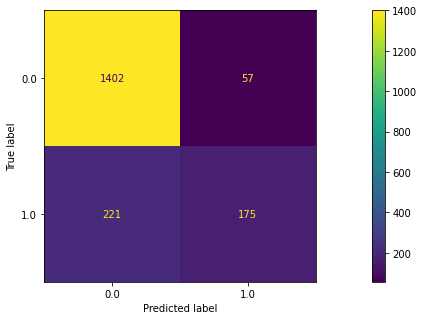

In [65]:
# Determining classification report for train set
print('Classification Score')
print(classification_report(y_train_final,y_pred_train_ada))

# Get F1 Score, Precision Score and Recall Score - Train Set
print('F1 Score (Train Set)  : ', f1_score(y_train_final, y_pred_train_ada))
print('Precision (Train Set) : ', precision_score(y_train_final, y_pred_train_ada))
print('Recall (Train Set)    : ', recall_score(y_train_final, y_pred_train_ada), '\n')
print('Accuracy (Train Set)  : ', accuracy_score(y_train_final, y_pred_train_ada), '\n')

# Creating confusion matrix for train set
print('Confusion Matrix Train Set')
cm = confusion_matrix(y_train_final, y_pred_train_ada, labels=ada.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=ada.classes_)

disp.plot()
plt.show()

#### **Hyperparameter**

AdaBoost Classifier is a developed ensamble learning with an important parameter such as **the base estimator**, then we should check the default AdaBoostClassifer firstly. The base estimator is basically other algorithms with **the default is DecisionTreeClassifier**.

In [69]:
# Define Hyperparameters
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=3))

n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num = 7)]
learning_rate = [(0.97 + x / 100) for x in range(0, 8)]

param_grid = {'base_estimator__max_depth':[i for i in range(3,8,2)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':n_estimators,
              'learning_rate':learning_rate,
              'algorithm': ['SAMME', 'SAMME.R']}
param_grid

{'base_estimator__max_depth': [3, 5, 7],
 'base_estimator__min_samples_leaf': [5, 10],
 'n_estimators': [10, 25, 40, 55, 70, 85, 100],
 'learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04],
 'algorithm': ['SAMME', 'SAMME.R']}

In [70]:
# Train with Grid Search
%%time
ada_gridcv = GridSearchCV(ada,
                          param_grid,
                          n_jobs=-1,
                          verbose=2,
                          scoring='f1')
ada_gridcv.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits
CPU times: user 11min 44s, sys: 9.74 s, total: 11min 54s
Wall time: 35min 3s


GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=3)),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator__max_depth': [3, 5, 7],
                         'base_estimator__min_samples_leaf': [5, 10],
                         'learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01, 1.02,
                                           1.03, 1.04],
                         'n_estimators': [10, 25, 40, 55, 70, 85, 100]},
             scoring='f1', verbose=2)

In [118]:
# Train with Grid Search (Tes set)
%%time
ada_gridcv_test = GridSearchCV(ada,
                          param_grid,
                          n_jobs=-1,
                          verbose=2,
                          scoring='f1')
ada_gridcv_test.fit(X_test_final, y_test_final)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits
CPU times: user 6min 2s, sys: 4.94 s, total: 6min 7s
Wall time: 17min 25s


GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=3)),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator__max_depth': [3, 5, 7],
                         'base_estimator__min_samples_leaf': [5, 10],
                         'learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01, 1.02,
                                           1.03, 1.04],
                         'n_estimators': [10, 25, 40, 55, 70, 85, 100]},
             scoring='f1', verbose=2)

**Train-Test set with Hyperparameter Tuning**

In [75]:
# Display Best Hyperparamters from Grid Search for Train Set
ada_gridcv.best_params_

{'algorithm': 'SAMME.R',
 'base_estimator__max_depth': 3,
 'base_estimator__min_samples_leaf': 10,
 'learning_rate': 1.03,
 'n_estimators': 10}

In [120]:
# Display Best Hyperparamters from Grid Search for Test Set
ada_gridcv_test.best_params_

{'algorithm': 'SAMME',
 'base_estimator__max_depth': 3,
 'base_estimator__min_samples_leaf': 5,
 'learning_rate': 0.97,
 'n_estimators': 25}

In [121]:
# Get Best Estimator
ada_gridcv_best = ada_gridcv.best_estimator_
ada_gridcv_test_best = ada_gridcv_test.best_estimator_

In [122]:
# Predict the Train set results with tuned hyperparameter
y_pred_train_ada_final = ada_gridcv.predict(X_train_final)

# Predict the Test set results with tuned hyperparameter
y_pred_test_ada_final = ada_gridcv_test.predict(X_test_final)

y_pred_train_ada_final

array([0., 0., 1., ..., 0., 0., 0.])

## **8. Model Evaluation**

### **8.1. Train Set Hyperparameter Tuned Model Evaluation**

Accuracy - Train Set  :  0.9277628032345013 

F1 Score - Train Set  :  0.7330677290836654 

Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1623
           1       0.68      0.79      0.73       232

    accuracy                           0.93      1855
   macro avg       0.83      0.87      0.85      1855
weighted avg       0.93      0.93      0.93      1855
 

Confusion Matrix Train Set


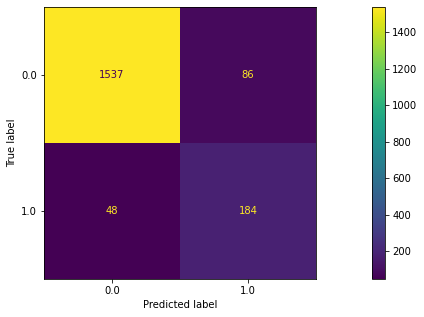

In [96]:
# Evaluating Train set with tuned hyperparameter
print('Accuracy - Train Set  : ', accuracy_score(y_pred_train_ada, y_pred_train_ada_final), '\n')
print('F1 Score - Train Set  : ', f1_score(y_pred_train_ada, y_pred_train_ada_final), '\n')
print('Classification Report : \n', classification_report(y_pred_train_ada, y_pred_train_ada_final), '\n')

# Creating confusion matrix for train set
print('Confusion Matrix Train Set')
cm = confusion_matrix(y_pred_train_ada, y_pred_train_ada_final, labels=ada_gridcv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=ada_gridcv.classes_)

disp.plot()
plt.show()

**Cross Validation**

The model is evaluated by cross-validation as well and we can see apparently **F1-score mean and standard deviation cross-validation is increasing compared wiht the Baseline (Default Hyperparameter)**.

In [101]:
# Cross Validation using `cross_val_score` for train set, F1 Score
cross_val_train_f1 = cross_val_score(ada_gridcv_best, X_train_final, y_pred_train_ada_final, cv=5, scoring='f1')

print("F1 Score All - Cross Validation          :", cross_val_train_f1)
print("F1 Mean - Cross-Validation               :", cross_val_train_f1.mean())
print("F1 Standard Deviation Cross-Validation   :", cross_val_train_f1.std())

F1 Score All - Cross Validation          : [0.72727273 0.60869565 0.48       0.71028037 0.62365591]
F1 Mean - Cross-Validation               : 0.6299809334513821
F1 Standard Deviation Cross-Validation   : 0.08820549046371298


In [102]:
# Cross Validation using `cross_val_score` for train set, Accuracy
cross_val_train_acc = cross_val_score(ada_gridcv_best, X_train_final, y_pred_train_ada_final, cv=5, scoring='accuracy')

print("F1 Score All - Cross Validation          :", cross_val_train_acc)
print("F1 Mean - Cross-Validation               :", cross_val_train_acc.mean())
print("F1 Standard Deviation Cross-Validation   :", cross_val_train_acc.std())

F1 Score All - Cross Validation          : [0.92722372 0.90296496 0.85983827 0.91644205 0.90566038]
F1 Mean - Cross-Validation               : 0.9024258760107816
F1 Standard Deviation Cross-Validation   : 0.02296015033859498


### **8.2. Test Set Hyperparameter Tuned Model Evaluation**

Apparently, the confusion matrix shows that False Positive (1 predicted - 0 true) is outnumbering True Negative (1-1). This should be noticed that test set might be having an imbalance data which should have been handled during the features selection.

Accuracy - Test Set  :  0.8897243107769424 

F1 Score - Test Set  :  0.5555555555555556 

Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94       719
           1       0.46      0.70      0.56        79

    accuracy                           0.89       798
   macro avg       0.71      0.80      0.75       798
weighted avg       0.91      0.89      0.90       798
 

Confusion Matrix


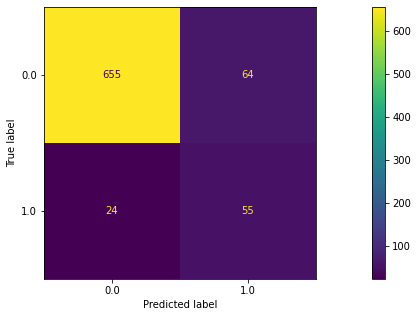

In [123]:
# Evaluating test set with tuned hyperparameter
print('Accuracy - Test Set  : ', accuracy_score(y_pred_test_ada, y_pred_test_ada_final), '\n')
print('F1 Score - Test Set  : ', f1_score(y_pred_test_ada, y_pred_test_ada_final), '\n')
print('Classification Report : \n', classification_report(y_pred_test_ada, y_pred_test_ada_final), '\n')

# Creating confusion matrix for test set
print('Confusion Matrix')
cm = confusion_matrix(y_pred_test_ada, y_pred_test_ada_final, labels=ada_gridcv_test.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=ada_gridcv_test.classes_)

disp.plot()
plt.show()

However, overall cross-validation shows that test set with hyperparamter tuned is increasing, although not sighnificantly, but it shows that hyperparameter tuning works for this classification.

In [124]:
# Cross Validation using `cross_val_score` for test set, F1 Score
cross_val_test_f1 = cross_val_score(ada_gridcv_test_best, X_test_final, y_pred_test_ada_final, cv=5, scoring='f1')

print("F1 Score All - Cross Validation          :", cross_val_test_f1)
print("F1 Mean - Cross-Validation               :", cross_val_test_f1.mean())
print("F1 Standard Deviation Cross-Validation   :", cross_val_test_f1.std())

F1 Score All - Cross Validation          : [0.68181818 0.42424242 0.57894737 0.53061224 0.6       ]
F1 Mean - Cross-Validation               : 0.5631240438759236
F1 Standard Deviation Cross-Validation   : 0.08490422070355355


In [125]:
# Cross Validation using `cross_val_score` for test set, Accuracy
cross_val_test_acc = cross_val_score(ada_gridcv_test_best, X_test_final, y_pred_test_ada_final, cv=5, scoring='accuracy')

print("F1 Score All - Cross Validation          :", cross_val_test_acc)
print("F1 Mean - Cross-Validation               :", cross_val_test_acc.mean())
print("F1 Standard Deviation Cross-Validation   :", cross_val_test_acc.std())

F1 Score All - Cross Validation          : [0.9125     0.88125    0.9        0.85534591 0.89937107]
F1 Mean - Cross-Validation               : 0.8896933962264152
F1 Standard Deviation Cross-Validation   : 0.019854799051363888


### **8.3. Comparison of Hyperparameter Default vs Tuned Classification Report**

In [126]:
# Save Classification Report into a Dictionary

all_reports = {}
score_reports = {
    'train - precision' : precision_score(y_train_final, y_pred_train_ada),
    'train - recall' : recall_score(y_train_final, y_pred_train_ada),
    'train - accuracy' : accuracy_score(y_train_final, y_pred_train_ada),
    'train - f1_score' : f1_score(y_train_final, y_pred_train_ada),
    'test - precision' : precision_score(y_test_final, y_pred_test_ada),
    'test - recall' : recall_score(y_test_final, y_pred_test_ada),
    'test - accuracy' : accuracy_score(y_test_final, y_pred_test_ada),
    'test - f1_score' : f1_score(y_test_final, y_pred_test_ada),
}
all_reports['Baseline (Default Hyperparameter)'] = score_reports
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter)
test - accuracy,0.828321
test - f1_score,0.454183
test - precision,0.721519
test - recall,0.331395
train - accuracy,0.850135
train - f1_score,0.557325
train - precision,0.754310
train - recall,0.441919


In [127]:
score_reports = {
    'train - precision' : precision_score(y_train_final, y_pred_train_ada_final),
    'train - recall' : recall_score(y_train_final, y_pred_train_ada_final),
    'train - accuracy' : accuracy_score(y_train_final, y_pred_train_ada_final),
    'train - f1_score' : f1_score(y_train_final, y_pred_train_ada_final),
    'test - precision' : precision_score(y_test_final, y_pred_test_ada_final),
    'test - recall' : recall_score(y_test_final, y_pred_test_ada_final),
    'test - accuracy' : accuracy_score(y_test_final, y_pred_test_ada_final),
    'test - f1_score' : f1_score(y_test_final, y_pred_test_ada_final),
}
all_reports['Grid Search'] = score_reports

pd.DataFrame(all_reports).sort_index()

,Baseline (Default Hyperparameter),Grid Search
test - accuracy,0.828321,0.918546
test - f1_score,0.454183,0.776632
test - precision,0.721519,0.949580
test - recall,0.331395,0.656977
train - accuracy,0.850135,0.865229
train - f1_score,0.557325,0.624625
train - precision,0.754310,0.770370
train - recall,0.441919,0.525253


The table above shows the comparison of Baseline Hyperparameter with Grid Search. It can be seen that the accuracy and F1-Score are increased for both train and test set, which means the hyperparameter tuning is basically working. Following F1-Score, precision and recall are highly influencing to F1-Score, also increasing after hyperparameter is tuned.

This means hyperparamter works and the class--both 0 (non-default payment) and 1 (default payment)--are **perfectly handled by the model with tuned hyperparameters**.

However, it should be noted that there is a tendency to be overfitting, by seeing the result of precision from test set, which is from 72% to 94%. This means, **the hyperparamter tuning definition needs to be refined for test set to avoid overfitting**.

## **9. Model Inference**

### **9.1. Save and Load Model**

In [113]:
# Save the model files
with open('ada_gridcv.pkl', 'wb') as file_1:
  joblib.dump(ada_gridcv, file_1)

with open('model_scaler.pkl', 'wb') as file_2:
  joblib.dump(scaler, file_2)

with open('model_onehotencoder.pkl', 'wb') as file_3:
  joblib.dump(ohc, file_3)

with open('model_ordinalencoder.pkl', 'wb') as file_4:
  joblib.dump(enc, file_4)

with open('model_labelencoder.pkl', 'wb') as file_5:
  joblib.dump(le, file_5)

with open('num_columns.txt', 'w') as file_6:
  json.dump(num_columns, file_6)

with open('cat_columns.txt', 'w') as file_7:
  json.dump(cat_columns, file_7)

In [114]:
# Load all model files
with open('ada_gridcv.pkl', 'rb') as file_1:
  ada_gridcv = joblib.load(file_1)

with open('model_scaler.pkl', 'rb') as file_2:
  model_scaler = joblib.load(file_2)

with open('model_onehotencoder.pkl', 'rb') as file_3:
  model_onehotencoder = joblib.load(file_3)

with open('model_ordinalencoder.pkl', 'rb') as file_4:
  model_ordinalencoder = joblib.load(file_4)

with open('model_labelencoder.pkl', 'rb') as file_5:
  model_labelencoder = joblib.load(file_5)

with open('num_columns.txt', 'r') as file_6:
  num_columns = json.load(file_6)

with open('cat_columns.txt', 'r') as file_7:
  cat_columns = json.load(file_7)

### **9.2. Features Selection**

In [177]:
# Defining y
y_inf = pd.DataFrame(df_inf['default_payment_next_month'])

# Using OrdinalEncoder to encode target train and test set
enc = OrdinalEncoder()

y_inf_encode = y_inf.copy()
enc.fit(y_inf_encode[['default_payment_next_month']])
y_inf_encode[['default_payment_next_month']] = enc.transform(y_inf_encode[['default_payment_next_month']])
y_inf_encode = y_inf_encode['default_payment_next_month']

y_inf = pd.DataFrame(y_inf_encode).sort_index()
y_inf

,default_payment_next_month
7,0.0
18,0.0
23,0.0
26,0.0
69,0.0
...,...
2858,0.0
2883,0.0
2952,1.0
2959,1.0


In [115]:
# Calling numerical columns from the loaded model
num_columns

['limit_balance',
 'age',
 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
 'bill_amt_1',
 'bill_amt_2',
 'bill_amt_3',
 'bill_amt_4',
 'bill_amt_5',
 'bill_amt_6',
 'pay_amt_1',
 'pay_amt_2',
 'pay_amt_3',
 'pay_amt_4',
 'pay_amt_5',
 'pay_amt_6']

In [128]:
# Calling categorical columns from the loaded model
cat_columns

['sex', 'education_level', 'marital_status']

**Numerical Features**

In [147]:
# Split between Numerical Columns and Categorical Columns of data inference
df_inf_num = df_inf[num_columns]
df_inf_cat = df_inf[cat_columns]
df_inf_num

,limit_balance,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
7,130000.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,130067.0,129385.0,96775.0,98071.0,97743.0,100124.0,5540.0,4403.0,3814.0,3562.0,4021.0,3681.0
18,50000.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,49073.0,49531.0,44002.0,44356.0,19344.0,19354.0,1691.0,1942.0,1296.0,674.0,693.0,1000.0
23,140000.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,130767.0,134946.0,130470.0,132038.0,131961.0,124256.0,6696.0,5000.0,4866.0,5300.0,5055.0,5000.0
26,80000.0,29.0,0.0,0.0,2.0,2.0,0.0,0.0,52533.0,56340.0,57022.0,55081.0,55350.0,55906.0,5120.0,2600.0,0.0,2200.0,2028.0,3000.0
69,80000.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,79518.0,77757.0,32325.0,25670.0,30089.0,29395.0,2264.0,1420.0,1002.0,6005.0,2000.0,970.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2858,130000.0,25.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,390.0,390.0,36659.0,23150.0,27376.0,33104.0,780.0,36659.0,5000.0,5000.0,7000.0,5000.0
2883,310000.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,29906.0,14780.0,18261.0,41540.0,50803.0,59927.0,14750.0,5000.0,24000.0,10000.0,10000.0,30000.0
2952,20000.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,10085.0,11416.0,12520.0,12714.0,13059.0,13193.0,1500.0,1600.0,700.0,700.0,500.0,1000.0
2959,120000.0,54.0,1.0,-2.0,-2.0,-2.0,-1.0,-1.0,-200.0,-200.0,-200.0,0.0,700.0,1935.0,0.0,0.0,200.0,700.0,1935.0,0.0


In [148]:
# Feature Scaling for data inference
df_inf_num_scaled = model_scaler.transform(df_inf_num)
df_inf_num_scaled = pd.DataFrame(df_inf_num_scaled, columns = df_inf_num.columns, index = df_inf_num.index)
df_inf_num_scaled

,limit_balance,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
7,0.244898,0.458333,0.2,0.222222,0.222222,0.222222,0.222222,0.222222,0.274158,0.390734,0.248059,0.280932,0.287026,0.367482,0.030074,0.007585,0.021898,0.022310,0.017397,0.016124
18,0.081633,0.395833,0.2,0.222222,0.222222,0.222222,0.222222,0.222222,0.107673,0.232279,0.125284,0.160749,0.072641,0.171314,0.009180,0.003346,0.007441,0.004222,0.002998,0.004380
23,0.265306,0.166667,0.2,0.222222,0.222222,0.222222,0.222222,0.222222,0.275597,0.401769,0.326449,0.356931,0.380597,0.426092,0.036349,0.008614,0.027938,0.033196,0.021871,0.021901
26,0.142857,0.166667,0.2,0.222222,0.444444,0.444444,0.222222,0.222222,0.114785,0.245790,0.155575,0.184746,0.171101,0.260089,0.027794,0.004479,0.000000,0.013779,0.008774,0.013141
69,0.142857,0.562500,0.2,0.222222,0.222222,0.222222,0.222222,0.222222,0.170253,0.288288,0.098118,0.118941,0.102023,0.195701,0.012290,0.002446,0.005753,0.037612,0.008653,0.004249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2858,0.244898,0.083333,0.1,0.111111,0.111111,0.222222,0.222222,0.222222,0.007603,0.134767,0.108201,0.113303,0.094604,0.204709,0.004234,0.063155,0.028708,0.031317,0.030286,0.021901
2883,0.612245,0.166667,0.2,0.222222,0.222222,0.222222,0.222222,0.222222,0.068274,0.163321,0.065399,0.154449,0.158667,0.269855,0.080071,0.008614,0.137797,0.062634,0.043265,0.131406
2952,0.020408,0.062500,0.2,0.222222,0.222222,0.222222,0.222222,0.222222,0.027532,0.156646,0.052043,0.089953,0.055454,0.156351,0.008143,0.002756,0.004019,0.004384,0.002163,0.004380
2959,0.224490,0.687500,0.3,0.000000,0.000000,0.000000,0.111111,0.111111,0.006391,0.133596,0.022450,0.061507,0.021658,0.129009,0.000000,0.000000,0.001148,0.004384,0.008372,0.000000


**Categorical Features**

In [149]:
# Feature Encoding for data inference
df_inf_cat

,sex,education_level,marital_status
7,2,3,1
18,1,2,1
23,1,2,1
26,2,2,1
69,2,2,1
...,...,...,...
2858,2,2,2
2883,2,1,2
2952,1,2,1
2959,2,2,1


In [155]:
# Encoding OneHotEncoder (ohc) based on the encoded X_train_cat
df_inf_cat_encoded = model_onehotencoder.transform(df_inf_cat).toarray()
df_inf_cat_encoded = pd.DataFrame(df_inf_cat_encoded, index=df_inf_cat.index).sort_index()

# Drop features 
df_inf_cat_encoded = df_inf_cat_encoded.drop([2,3,4,5,6],axis=1)
df_inf_cat_encoded

,0,1,7,8,9,10
7,0.0,1.0,0.0,1.0,0.0,0.0
18,1.0,0.0,0.0,1.0,0.0,0.0
23,1.0,0.0,0.0,1.0,0.0,0.0
26,0.0,1.0,0.0,1.0,0.0,0.0
69,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
2858,0.0,1.0,0.0,0.0,1.0,0.0
2883,0.0,1.0,0.0,0.0,1.0,0.0
2952,1.0,0.0,0.0,1.0,0.0,0.0
2959,0.0,1.0,0.0,1.0,0.0,0.0


### **9.3. Concatenate Scaled and Encoded Features**

In [156]:
# Concatenate Numerical Columns and Categorical Columns
df_inf_final = pd.concat([df_inf_cat_encoded, df_inf_num_scaled], axis=1)
df_inf_final = df_inf_final.sort_index()
df_inf_final

,0,1,7,8,9,10,limit_balance,age,pay_0,pay_2,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
7,0.0,1.0,0.0,1.0,0.0,0.0,0.244898,0.458333,0.2,0.222222,...,0.248059,0.280932,0.287026,0.367482,0.030074,0.007585,0.021898,0.022310,0.017397,0.016124
18,1.0,0.0,0.0,1.0,0.0,0.0,0.081633,0.395833,0.2,0.222222,...,0.125284,0.160749,0.072641,0.171314,0.009180,0.003346,0.007441,0.004222,0.002998,0.004380
23,1.0,0.0,0.0,1.0,0.0,0.0,0.265306,0.166667,0.2,0.222222,...,0.326449,0.356931,0.380597,0.426092,0.036349,0.008614,0.027938,0.033196,0.021871,0.021901
26,0.0,1.0,0.0,1.0,0.0,0.0,0.142857,0.166667,0.2,0.222222,...,0.155575,0.184746,0.171101,0.260089,0.027794,0.004479,0.000000,0.013779,0.008774,0.013141
69,0.0,1.0,0.0,1.0,0.0,0.0,0.142857,0.562500,0.2,0.222222,...,0.098118,0.118941,0.102023,0.195701,0.012290,0.002446,0.005753,0.037612,0.008653,0.004249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2858,0.0,1.0,0.0,0.0,1.0,0.0,0.244898,0.083333,0.1,0.111111,...,0.108201,0.113303,0.094604,0.204709,0.004234,0.063155,0.028708,0.031317,0.030286,0.021901
2883,0.0,1.0,0.0,0.0,1.0,0.0,0.612245,0.166667,0.2,0.222222,...,0.065399,0.154449,0.158667,0.269855,0.080071,0.008614,0.137797,0.062634,0.043265,0.131406
2952,1.0,0.0,0.0,1.0,0.0,0.0,0.020408,0.062500,0.2,0.222222,...,0.052043,0.089953,0.055454,0.156351,0.008143,0.002756,0.004019,0.004384,0.002163,0.004380
2959,0.0,1.0,0.0,1.0,0.0,0.0,0.224490,0.687500,0.3,0.000000,...,0.022450,0.061507,0.021658,0.129009,0.000000,0.000000,0.001148,0.004384,0.008372,0.000000


### **9.4. Model Training Inference**

In modeling inference, we will get the binary results (0 and 1) which means:
- `0` for non-default payment next month
- `1` for default payment next month

In [159]:
# Predict using Linear regression
y_pred_inf = ada_gridcv.predict(df_inf_final)

# Create DataFrame
y_pred_inf_df = pd.DataFrame(y_pred_inf, columns=['Predicted (Inference)'],index=df_inf_final.index)
y_pred_inf_df

,Predicted (Inference)
7,0.0
18,0.0
23,0.0
26,0.0
69,0.0
...,...
2858,0.0
2883,0.0
2952,0.0
2959,0.0


In [183]:
# Comparing the real income bracket and predicted classification
model_inf = pd.concat([df_inf['default_payment_next_month'], y_pred_inf_df['Predicted (Inference)']], axis=1).sort_index()
model_inf

,default_payment_next_month,Predicted (Inference)
7,0.0,0.0
18,0.0,0.0
23,0.0,0.0
26,0.0,0.0
69,0.0,0.0
...,...,...
2858,0.0,0.0
2883,0.0,0.0
2952,1.0,0.0
2959,1.0,0.0


### **9.5. Model Evaluation Inference**

However, the evaluation for inference target is apparently not good if we use the train model with hyperparameter tuned. The result can be seen that F1-score is good only for class-0 (non-default payment), but there is stil some error predicition with class-1 which is why the score is very low.

For the accuracy of the model itself, it is suggested to use `pipeline` for the model.

Accuracy - Inference Set  :  0.7933333333333333 

F1 Score - Inference Set  :  0.40384615384615385 

Classification Report : 
               precision    recall  f1-score   support

         0.0       0.83      0.93      0.87       233
         1.0       0.57      0.31      0.40        67

    accuracy                           0.79       300
   macro avg       0.70      0.62      0.64       300
weighted avg       0.77      0.79      0.77       300
 

Confusion Matrix


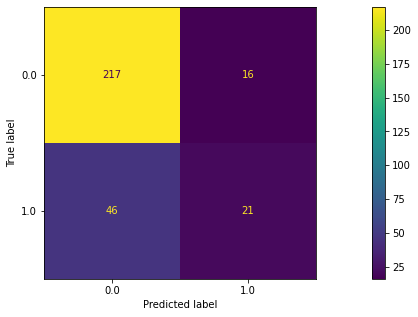

In [187]:
# Evaluating test set with tuned hyperparameter
print('Accuracy - Inference Set  : ', accuracy_score(y_inf, y_pred_inf), '\n')
print('F1 Score - Inference Set  : ', f1_score(y_inf, y_pred_inf), '\n')
print('Classification Report : \n', classification_report(y_inf, y_pred_inf), '\n')

# Creating confusion matrix for test set
print('Confusion Matrix')
cm = confusion_matrix(y_inf, y_pred_inf, labels=ada_gridcv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=ada_gridcv.classes_)

disp.plot()
plt.show()

## **10. Conclusion and Suggestion**

There many takeaways we can get from Default Payment analysis:

- In general conclusion: It is **predicted true** based on train and test set that **number of non-default payment is higher than default payment**. This can be observed by confusion model on part `8. Model Evaluation`.

- The model accuracy scores are determined by various evaluation method, such as cross-validation, F1-scores, and Accuracy percentage. We can see that the hyperparameter tuning is working for the model as the increasing number of scores. However, as mentioned in part `8.3. Comparison of Hyperparameter Default vs Tuned Classification Report`, although the classes are perfectly working to model, the overfitting should be noticed as well. The details as below:

In [191]:
pd.DataFrame(all_reports).sort_index()

,Baseline (Default Hyperparameter),Grid Search
test - accuracy,0.828321,0.918546
test - f1_score,0.454183,0.776632
test - precision,0.721519,0.949580
test - recall,0.331395,0.656977
train - accuracy,0.850135,0.865229
train - f1_score,0.557325,0.624625
train - precision,0.754310,0.770370
train - recall,0.441919,0.525253


- Some features such as the target need to be checked its balance. The imbalance data will create a skewed model as we can see on part `4. Exploratory Data Analysis (EDA)`, and the worst is that the prediciton will be biased or error when it is not handled correctly.

---
#### **Conceptual Problems**

*1. What is the function of `criterion` parameter in Decision Tree?*
> We can see from AdaBoostClassifier model that the base estimator is DecisionTreeClassifier (which is the default estimator for AdaBoostClassifier). Criterion is used to construct the analysis methods, such as `gini` and `entropy`. `Gini` is **impurity of the nodes**, it uses probability in its calculation so the result will be between 0 and 1. Meanwhile `entropy` **represents order of randomness**. Both of them are the same concept, where the lower the gini/entropy is, the better is the purity of the classification.

*2. What is `pruning` in Tree models?*
> Pruning **reduces the size of trees** by removing parts of the tree that do not provide power to classify instances, since tree models are the most susceptible out of all the machine learning algorithms to **overfitting**. So, pruning is useful to cut out the part of trees and avoid overfitting.

*3. How to choose K optimally in KNN?*
> By deciding number of neighbors (K) that will be used as the class. `K` in KNN is a parameter that refers to **the number of nearest neighbours to include in the majority of the voting process**. The small K value isn’t suitable for classification.

*4. What is cross-validation?*
> Cross-validation is to assessing how the results of a statistical analysis that is generalized from an independent data set, which data comes from the training data. From here, **cross-validation can determine the best parameters** that will be used in training the model to avoid default parameters from overfitting.

*5. What are `Accuracy`, `Precision`, `Recall`, and `F1 Score`?*
> - **Recall**: tells how many times the model is able to detect a specific category. Recall is basically the ratio of the number of actual label (or true label) toward prediction.
- **Precision**: tells how good the model is at predicting a specific category. As the opposite concept from recall, precision is the ration of the number of predicitions toward the actual/true label.
- **F1 Score**: it sums up the predictive performance of a model by combining two otherwise competing metrics — `precision` and `recall`. F1 score is an important evaluation metrics, useful when the quantity of examples belonging to one class significantly outnumbers those found in the other class.
- **Accuracy**: it is the ratio of the classification, or predictions if the model got right.